# Final Project: Debevec-Malik Method

By: Oroni Hasan

Email: o3hasan@uwaterloo.ca

## Abstract
The range of luminance on a screen is 100 times smaller than the range of luminance we perceive with our eyes, so obtaining the desired high dynamic range tends to be difficult when taking pictures. Pictures may often come out overexposed or underexposed since photographic sensors have a hard time picking up the much greater range of luminance in the natural world. The Debevec-Mailk method offers a solution that combines these photos taken at different exposure levels to create an aggregated, well-exposed photograph with a higher dynamic range compared to any of the bracketed photos individually.

The method first involves estimating a radiometric response function $f$, which denotes the monotonic relationship between the brightness in the environment and the brightness in the image. It can help us find the unknown irradiance at each pixel, $E_i$, of each bracketed image $j$. The measured exposure value at each pixel is thus $z_{ij} = f(E_it_j)$ where $t_j$ is the known exposure time of image $j$. The log of the inverse of this expression, $g(z_{ij}) = \log(f^{-1}(z_{ij})) = \log(E_i) + \log(t_j)$, is the curve we are estimating to find the log exposure values corresponding to pixel values of each image. Once the response function $g$ is found, it can be used to find the radiance values of the bracketed images, which are merged to form a radiance map of the final HDR image. While not part of the Debevec-Malik method, the last step is tone-mapping, which involves using a global transfer curve to compress the high dynamic range in the radiance map into the low dynamic range displayable gamut, resulting in our final HDR image.


## Code Libraries

In [13]:
import numpy as np # for vector operations
import matplotlib
import matplotlib.image as image # for importing photos
import matplotlib.pyplot as plt # for plotting images and response curves
import cv2 # will be useful for tone mapping

## Estimating Radiometric Response Function

As mentioned in the introduction, we will find the set of curves $g(z_{ij})$; we want to find the set of values of $g$ and $\log(E_i)$ that will minimize the least-squares problem:

$E = \sum_{i=1}^N\sum_{j=1}^Pw(z_{ij})[g(z_{ij}) - \log E_i - \log t_j]^2 + \lambda \sum_{z= z_{min}}^{z_{max}}[w(z)g''(z)]^2$ where $i$ iterates over $N$ pixel locations and $j$ iterates over $P$ photographs. The second term of this problem is a smoothness term where $g''(z) = g(z-1)-2g(z)+g(z+1)$. Additionally, since $g$ will emphasize extreme pixel values, $w$ is a weight function to create a more even distribution by emphasizing the middle of the curve, defined as 
$w(z) = \begin{equation}
    \begin{cases}
      z - z_{min}, \text{ for } z \leq \frac{1}{2}(z_{min}+z_{max})\\
      z_{max} - z, \text{ for } z > \frac{1}{2}(z_{min}+z_{max})
    \end{cases}
\end{equation}$

In [14]:
# The following comments and algorithm are based on the MATLAB code provided by Debevec and Malik

# Given a set of pixel values observed for several pixels in several
# images with different exposure times, this function returns the
# imaging system’s response function g as well as the log film irradiance
# values for the observed pixels.

# Assumes:
# Zmin = 0
# Zmax = 255

# Arguments:
# Z(i,j) is the pixel values of pixel location number i in image j
# B(j) is the log exposure time for image j
# l is lamdba, the constant that determines the amount of smoothness
# w(z) is the weighting function value for pixel value z

# Returns:
# g(z) is the log exposure corresponding to pixel value z
# lE(i) is the log film irradiance at pixel location i

def response(Z, B, l, w):
    n = 256;
    num_pixels = Z.shape[0]
    num_images = Z.shape[1]
    k = num_pixels*num_images
    A = np.zeros((k+n+1, num_pixels+n), dtype=np.float32);
    b = np.zeros((A.shape[0],1), dtype=np.float32);

    # Include the data−fitting equations
    z = Z.flatten() 
    B = np.repeat(B, num_pixels)
    i_indices = np.tile(np.arange(num_pixels), num_images)
    row_indices = np.arange(num_pixels * num_images)

    A[row_indices, z] = w[z]
    A[row_indices, n + i_indices] = -w[z]
    b[row_indices, 0] = w[z] * B

    # Fix the curve by setting its middle value to 0
    A[k, 128] = 1
    k+=1
    
    # Include the smoothness equations
    for i in range(n-2):
        A[k, i] = l*w[i+1]
        A[k, i+1] = -2*l*w[i+1]
        A[k, i+2] = l*w[i+1]
        k += 1
    
    # Solve the system using SVD
    x = np.linalg.lstsq(A, b, rcond=None)[0]
    g = x[:n]
    lE = x[n:]

    return g, lE
        

## Radiance Map

Once $g$ is found, the second step is to merge the bracketed images to form a composite radiance map. We can rearrange the expression for $g$ so that $\log E_i = g(z_{ij}) - \log t_j$. To obtain a high dynamic range and reduce noise in the final computed radiance of a pixel, we combine all exposure levels of a particular pixel across all the images, again using the weight function $w$ to emphasize the middle of the curve.
$$
\log E_i=\frac{\sum_{j=1}^P w\left(z_{i j}\right)\left(g\left(z_{i j}\right)-\log t_j\right)}{\sum_{j=1}^P w\left(z_{i j}\right)}
$$

In [15]:
def radiance_map(images, B, g, w, channel):
    height, width = images[0].shape[:2]
    num_images = len(images)
    num = np.zeros((height, width), dtype=np.float32)
    denom = np.zeros((height, width), dtype=np.float32)
    
    for j in range(num_images):
        z = images[j][:,:,channel]
        num += w[z]*(g[z].squeeze()-B[j])
        denom += w[z]

    ln_E = np.divide(num, denom, where=denom!=0)
   
    return ln_E

## Visualizing the Response Curves and Radiance Maps

This is the set of bracketed images we will be using and testing with, taken from EasyHDR

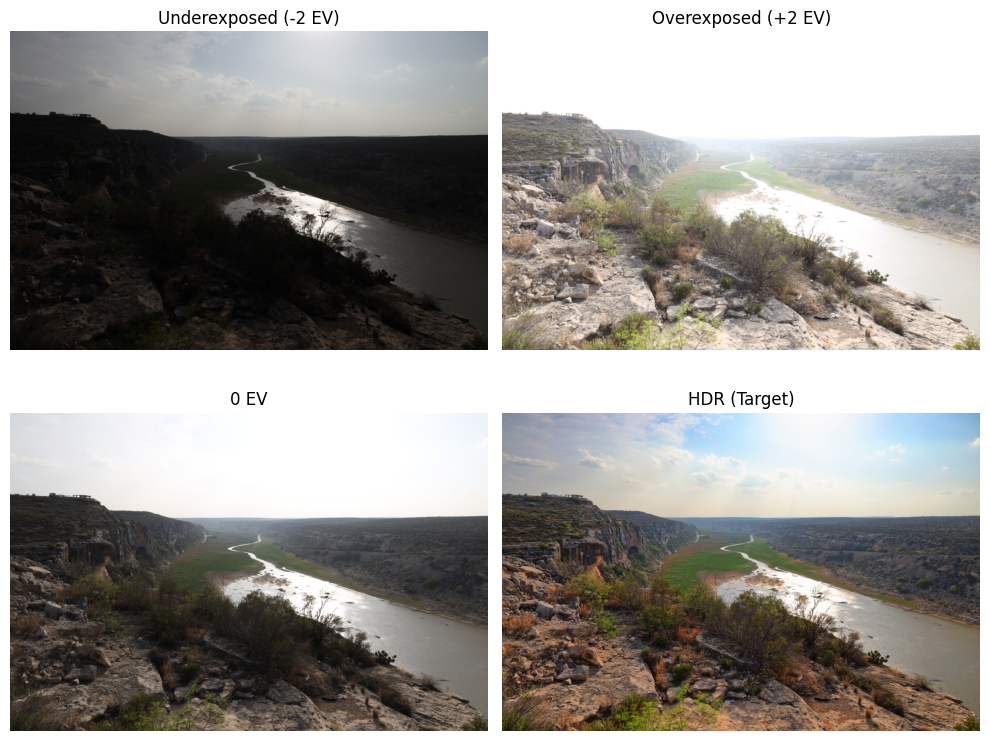

In [16]:
# images and exposures obtained from https://www.easyhdr.com/examples/pecos-river/

underexposed = image.imread('1-hasan/pecos-river1.jpg')
overexposed = image.imread('1-hasan/pecos-river3.jpg')
zero_ev = image.imread('1-hasan/pecos-river2.jpg')
hdr = image.imread('1-hasan/pecos-river.jpg')

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.imshow(underexposed)
plt.title("Underexposed (-2 EV)")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(overexposed)
plt.title("Overexposed (+2 EV)")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(zero_ev)
plt.title("0 EV")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(hdr)
plt.title("HDR (Target)")
plt.axis('off')

plt.tight_layout()
plt.show()


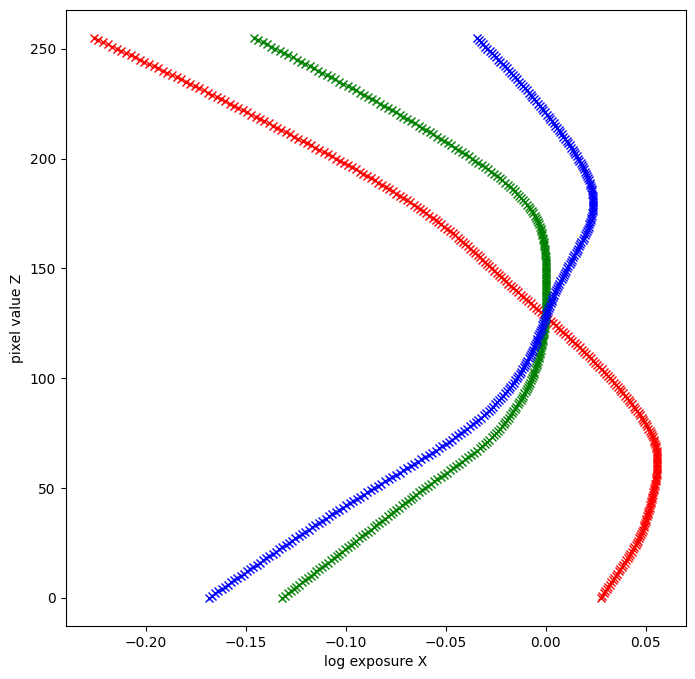

In [25]:
%matplotlib inline

images = np.array([underexposed, zero_ev, overexposed])
EVs = np.array([-2, 0, 2])
ISO = 100
f = 16
exposures = f**2 / (2.0**(-EVs) * ISO)
B = np.log(exposures, where=exposures>0).astype(np.float32).flatten()
l = 1000 # low smoothness constant will lead to more erratic looking images, and super squiggly response curves 
weights = np.array([z if z <= 255/2 else 255-z for z in range(256)])

# random sample pixel locations to increase efficiency & not all pixels in the image are needed, sampling a random subset tends to be sufficient enough to estimate the response curve
num_samples = 50
height, width, _ = images[0].shape
np.random.seed(42)
sampled_coords = [(np.random.randint(0, height), np.random.randint(0, width)) for _ in range(num_samples)]

Z_red = np.zeros((num_samples, len(images)), dtype=np.uint8)
Z_green = np.zeros_like(Z_red)
Z_blue = np.zeros_like(Z_red)

for j, img in enumerate(images):
    for i, (y, x) in enumerate(sampled_coords):
        Z_blue[i, j] = img[y, x, 0]
        Z_green[i, j] = img[y, x, 1]
        Z_red[i, j] = img[y, x, 2]

g_red, _ = response(Z_red, B, l, weights)
g_green, _ = response(Z_green, B, l, weights)
g_blue, _ = response(Z_blue, B, l, weights)

# plotting out response curves
plt.figure(figsize=(8,8))
plt.plot(g_red,range(256), 'rx')
plt.plot(g_green,range(256), 'gx')
plt.plot(g_blue,range(256), 'bx')
plt.ylabel('pixel value Z')
plt.xlabel('log exposure X')
plt.show()


More lower pixel values in the blue and green channels are being compressed compared to the red channel, so we may see less details in darker regions of the image. Details in brigher regions like the sky/river could also be lost as the red channel saturates early.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.078089096..1.6001554].


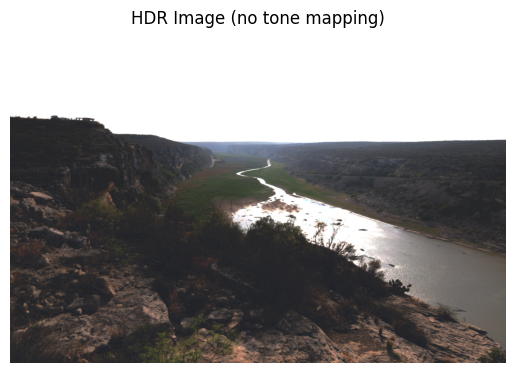

In [58]:
rad_map_r = np.exp(radiance_map(images, B, g_red, weights, 2))
rad_map_g = np.exp(radiance_map(images, B, g_green, weights, 1))
rad_map_b = np.exp(radiance_map(images, B, g_blue, weights, 0))

rad_map = np.dstack((rad_map_b, rad_map_g, rad_map_r))

plt.imshow(rad_map)
plt.title("HDR Image (no tone mapping)")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.078089096..1.6001554].


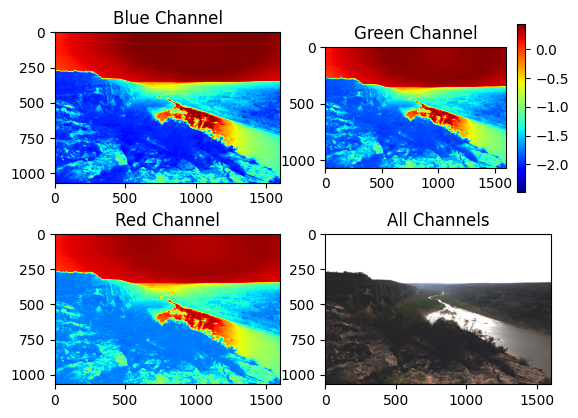

In [59]:
plt.subplot(221)
plt.imshow(radiance_map(images, B, g_blue, weights, 2), cmap='jet')
plt.title("Blue Channel")
plt.subplot(222)
plt.imshow(radiance_map(images, B, g_green, weights, 2), cmap='jet')
plt.title("Green Channel")
plt.colorbar()
plt.subplot(223)
plt.imshow(radiance_map(images, B, g_red, weights, 2), cmap='jet')
plt.title("Red Channel")
plt.subplot(224)
plt.imshow(rad_map, cmap='jet')
plt.title("All Channels")
plt.show()


## Tone-mapping

The next step after finding the radiance map is to be able to display the HDR image onto the screen which tends to have a lower dynamic range. There are many algorithms for tone-mapping but I will be focusing on bilateral filtering by Durand (2002) as it is one of the popular techniques that ensures edge preservation (e.g. no halos, sharp edges) while still blurring noise. The output of bilateral filtering involves each pixel being the weighted average of nearby pixels. For each pixel $s$, we have that $J_s = \frac{1}{k(s)}\sum_{p \in N}f(p-s)g(I_p-I_s)I_p$ where $f$ is a spatial kernel that determines the weighting of pixels based on their distance from $s$, $I$ is the intensity of the pixel, and $k$ is a normalization term, $k(s)= \sum_{p \in N}f(p-s)g(I_p-I_s)$. Thankfully there is already a function in cv2 that implements this.

Global tone mapping like Reinhard applies the same curve to every pixel in the image, which can result in a loss of detail or creating a flat-looking image:

In [20]:
def reinhard(im):
    return im / (1.0 + im)

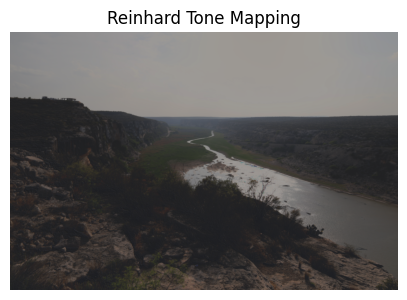

In [24]:
reinhard_im = reinhard(rad_map)
plt.figure(figsize=(5, 5))
plt.imshow(reinhard_im)
plt.title("Reinhard Tone Mapping")
plt.axis('off')
plt.show()

A local tone mapping technique like bilateral filtering tends to preserve more details as it adjusts luminance locally to each pixel based on nearby pixels. In the following, we split up the image into its chrominance channels which results in retaining luminance without changing colours. We use bilateral filtering to split the image into the "base" and "details" so that the details of the image are preserved while using the base layer to compress the dynamic range. 

In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# following pages 488-489 in section 10.2 of Szeliski

def tone_map(hdr_image, gamma=0.5, dR=4.0): # higher dR leads to greater contrast in image, more areas are darkened
    
    R = hdr_image[:, :, 0]
    G = hdr_image[:, :, 1]
    B = hdr_image[:, :, 2]
    
    #intensity = (R + G + B)/3
    intensity = 0.2126*R + 0.7152*G + 0.0722*B # https://en.wikipedia.org/wiki/Relative_luminance

    # computing chrominance channels
    r = R / intensity
    g = G / intensity
    b = B / intensity

    L = np.log(intensity) # log luminance image

    base = cv2.bilateralFilter(L, 5, 10, 20) # passed through bilateral filter to produce base layer

    detail = L - base # high pass detail layer

    scale = np.log(dR) / (np.max(base) - np.min(base)) # base layers contrast reduced by scaling to desired log-luminance range
    base_toned = (base - np.max(base)) * scale

    new_L = base_toned + detail # add detail layer to produce new log luminance
    
    new_intensity = 2 ** new_L

    new_R = new_intensity * r
    new_G = new_intensity * g
    new_B = new_intensity * b

    img = np.stack([new_R, new_G, new_B], axis=2)
    img_gamma = img ** (1 / gamma) # image is brighter for bigger gamma

    return img_gamma


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.005739460168163429..3.602795492149072].


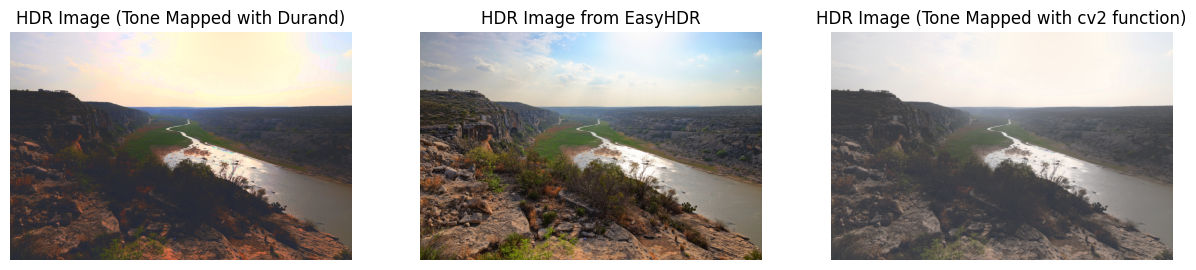

In [57]:
tone_mapped_img = tone_map(rad_map)

plt.figure(figsize=(15, 10))
plt.subplot(131)
plt.imshow(tone_mapped_img)
plt.title("HDR Image (Tone Mapped with Durand)")
plt.axis('off')
plt.subplot(132)
plt.imshow(hdr)
plt.title("HDR Image from EasyHDR")
plt.axis('off')

# Testing with the built-in cv2 version for comparison
tonemapDurand = cv2.createTonemap(2.2)
ldrDurand = tonemapDurand.process(rad_map)
im2_8bit = np.clip(ldrDurand * 255, 0, 255).astype('uint8')
plt.subplot(133)
plt.imshow(im2_8bit)
plt.title("HDR Image (Tone Mapped with cv2 function)")
plt.axis('off')

plt.show()


Compared to the Reinhard image, we notice that bilateral filtering has more brightness and contrast. It still has some dark areas with a loss of information compared to EasyHDR's image, which could be improved by adjusting the weight function to consider each colour channel instead of applying a simplistic weight function provided by the Debevec-Malik method which emphasizes mid-range values for pixels while the details in the brigher/darker regions of the image may be de-emphasized. As a result, this may not be suitable for an image that has a lot of small details in shadows like the image I'm using, as it lumps them into noise and clips them. 

Based on the graph of the response functions further up, we notice that a lot of low pixel values where shadows would be (cliffs/rocks) are being compressed, especially in the blue channel, which may have contributed to the dark patches in the final HDR image. Since the curve is relatively flat for the blue channel, there is not much pixel value change for small increments in exposure, which can compromise details despite reducing noise. Durand's tone-mapping might be contributing to this effect as it compresses the dynamic range of the base layer. The response graph also shows there was more emphasis on low-middle pixel values in the red channel whose curve then becomes flatter after saturating; in combination with de-emphasizing low pixel values in the blue chanel, this could be contributing to the yellowish halo around the sun, resulting in less details in the sky.